1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
    - 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
    - tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
    - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

In [1]:
import tensorflow as tf

In [2]:
# ResNet의 첫 conv 블록을 생성하는 함수
def conv2_resnet_block(x, is_50, is_plain):

    def conv_block(x, is_50):
        if is_50:
            x = tf.keras.layers.Conv2D(64, (1,1), strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.Conv2D(256, (1,1), strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
        else:
            x = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)

        return x

    if is_50:
        if is_plain:
            for _ in range(3):
                x = conv_block(x, is_50=True)
                x = tf.keras.layers.Activation('relu')(x)
        else:
            for _ in range(3):
                shortcut = tf.keras.layers.Conv2D(256, (1,1), strides=1, padding='same')(x)
                x = conv_block(x, is_50=True)
                x = tf.keras.layers.Add()([x, shortcut])
                x = tf.keras.layers.Activation('relu')(x)
    else:
        if is_plain:
            for _ in range(3):
                x = conv_block(x, is_50=False)
                x = tf.keras.layers.Activation('relu')(x)
        else:
            for _ in range(3):
                shortcut = tf.keras.layers.Conv2D(64, (1,1), strides=1, padding='same')(x)
                x = conv_block(x, is_50=False)
                x = tf.keras.layers.Add()([x, shortcut])
                x = tf.keras.layers.Activation('relu')(x)
                
    return x

In [3]:
# 전체 ResNet 블록을 생성하는 함수
def build_resnet_block(input_layer, num_cnn, channel, is_50=False, is_plain=False):
    
    x = input_layer

    if is_50:
        if is_plain:
            x = conv2_resnet_block(x, is_50=True, is_plain=True)
            for cnn in range(num_cnn):
                if cnn == 0:
                    x = tf.keras.layers.Conv2D(channel, (1,1), strides=2, padding='same')(x)
                else:
                    x = tf.keras.layers.Conv2D(channel, (1,1), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
        else:
            x = conv2_resnet_block(x, is_50=True, is_plain=False)
            for cnn in range(num_cnn):
                if cnn == 0:
                    shortcut = tf.keras.layers.Conv2D(channel*4, (1,1), strides=2, padding='same')(x)
                    x = tf.keras.layers.Conv2D(channel, (1,1), strides=2, padding='same')(x)
                else:
                    shortcut = tf.keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same')(x)
                    x = tf.keras.layers.Conv2D(channel, (1,1), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel*4, (1,1), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Add()([x, shortcut])
                x = tf.keras.layers.Activation('relu')(x)
    else:
        if is_plain:
            x = conv2_resnet_block(x, is_50=False, is_plain=True)
            for cnn in range(num_cnn):
                if cnn == 0:
                    x = tf.keras.layers.Conv2D(channel, (3,3), strides=2, padding='same')(x)
                else:
                    x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
        else:
            x = conv2_resnet_block(x, is_50=False, is_plain=False)
            for cnn in range(num_cnn):
                if cnn == 0:
                    shortcut = tf.keras.layers.Conv2D(channel, (1,1), strides=2, padding='same')(x)
                    x = tf.keras.layers.Conv2D(channel, (3,3), strides=2, padding='same')(x)
                else:
                    shortcut = x
                    x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Conv2D(channel, (3,3), strides=1, padding='same')(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation('relu')(x)
                x = tf.keras.layers.Add()([x, shortcut])
                x = tf.keras.layers.Activation('relu')(x)

    return x

In [4]:
# ResNet을 생성하는 함수
def build_resnet(input_shape, is_50=False, is_plain=False):
    
    num_cnns = [3, 4, 6, 3]
    channels = [64, 128, 256, 512]

    input_layer = tf.keras.layers.Input(shape=input_shape, dtype='float32')

    x = input_layer
    x = tf.keras.layers.Conv2D(64, (7,7), strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    for _, (num_cnn, channel) in enumerate(zip(num_cnns[1:], channels[1:])):
        x = build_resnet_block(
            input_layer=x,
            num_cnn=num_cnn,
            channel=channel,
            is_50=is_50,
            is_plain=is_plain,
        )
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='softmax', kernel_initializer='he_normal')(x)

    model = tf.keras.Model(
        inputs=input_layer,
        outputs=x
    )
    
    return model


In [5]:
# ResNet-34을 만들고 요약
resnet_34 = build_resnet(input_shape=(100, 100, 3), is_50=False, is_plain=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
# ResNet-50을 만들고 요약
resnet_50 = build_resnet(input_shape=(100, 100, 3), is_50=True, is_plain=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 50, 50, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_45 (BatchN  (None, 50, 50, 64)  256         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [7]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [8]:
# Tensorflow-datasets의 Cats vs Dogs 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:75%]', 'train[75%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

# 훈련 데이터와 검증 데이터의 크기
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(17446, shape=(), dtype=int64)
tf.Tensor(5816, shape=(), dtype=int64)


In [9]:
# 데이터를 정규화하고 이미지 크기를 통일시키는 함수 작성
def normalize_n_resize_img(image, label):
    image = tf.image.resize(image, [100, 100])
    image = (image / 255.0)
    return image, label

# 데이터셋에 위 함수를 적용하는 함수 작성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_n_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

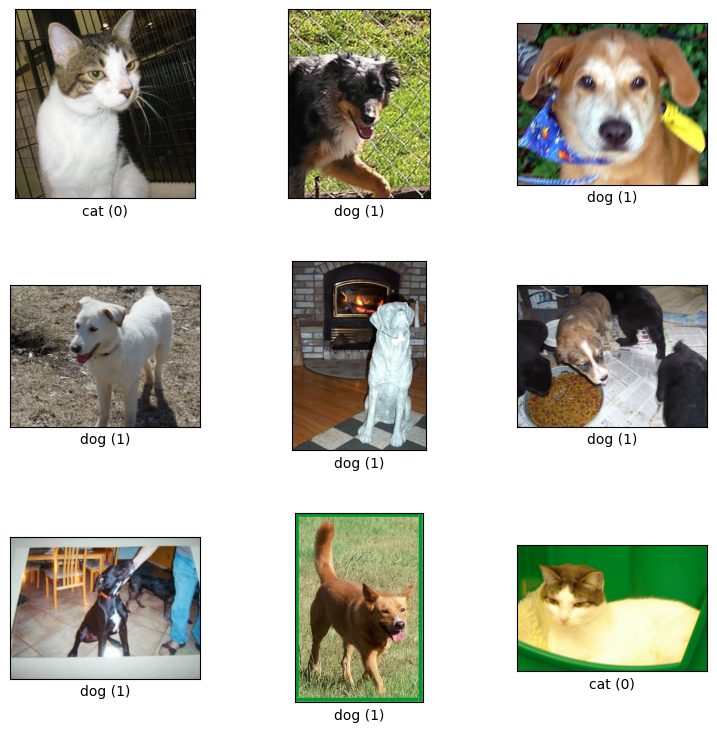

In [10]:
# 훈련 데이터의 예시를 출력
fig = tfds.show_examples(ds_train, ds_info)

In [11]:
# batch 크기와 epoch를 지정, 훈련 데이터와 검증 데이터에 정규화 함수 적용
BATCH_SIZE = 64
EPOCH = 20

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [12]:
# ResNet-34 모델을 컴파일하고 학습 진행
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.02, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:75%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[75%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


c:\Users\ZAKAR\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


272/272 [==============================] - 34s 89ms/step - loss: 1.1282 - accuracy: 0.5108 - val_loss: 0.7298 - val_accuracy: 0.5017
Epoch 2/20
272/272 [==============================] - 25s 90ms/step - loss: 0.8017 - accuracy: 0.6167 - val_loss: 1.0470 - val_accuracy: 0.6610
Epoch 3/20
272/272 [==============================] - 24s 87ms/step - loss: 0.7000 - accuracy: 0.6853 - val_loss: 1.9580 - val_accuracy: 0.7036
Epoch 4/20
272/272 [==============================] - 24s 88ms/step - loss: 0.6059 - accuracy: 0.7333 - val_loss: 1.0634 - val_accuracy: 0.7227
Epoch 5/20
272/272 [==============================] - 24s 88ms/step - loss: 0.4846 - accuracy: 0.7772 - val_loss: 1.2527 - val_accuracy: 0.5916
Epoch 6/20
272/272 [==============================] - 24s 90ms/step - loss: 0.4232 - accuracy: 0.8100 - val_loss: 0.4482 - val_accuracy: 0.7963
Epoch 7/20
272/272 [==============================] - 25s 91ms/step - loss: 0.3665 - accuracy: 0.8381 - val_loss: 0.4875 - val_accuracy: 0.7651
Epo

In [13]:
# ResNet-50 모델을 컴파일하고 학습 진행
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.02, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:75%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[75%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
272/272 [==============================] - 52s 155ms/step - loss: 0.9953 - accuracy: 0.4918 - val_loss: 0.8121 - val_accuracy: 0.5151
Epoch 2/20
272/272 [==============================] - 41s 151ms/step - loss: 0.8309 - accuracy: 0.5086 - val_loss: 0.7223 - val_accuracy: 0.4988
Epoch 3/20
272/272 [==============================] - 41s 151ms/step - loss: 0.8106 - accuracy: 0.5045 - val_loss: 3.9176 - val_accuracy: 0.5122
Epoch 4/20
272/272 [==============================] - 41s 151ms/step - loss: 0.7887 - accuracy: 0.5056 - val_loss: 0.8258 - val_accuracy: 0.5191
Epoch 5/20
272/272 [==============================] - 41s 151ms/step - loss: 0.7668 - accuracy: 0.5099 - val_loss: 0.8739 - val_accuracy: 0.5122
Epoch 6/20
272/272 [==============================] - 41s 151ms/step - loss: 0.7431 - accuracy: 0.5165 - val_loss: 1.2773 - val_accuracy: 0.5443
Epoch 7/20
272/272 [==============================] - 41s 151ms/step - loss: 0.7275 - accuracy: 0.5161 - val_loss: 1.3754 - val_ac

In [14]:
# ResNet-34 plain 모델을 만들고 요약
resnet_34_plain = build_resnet(input_shape=(100, 100, 3), is_50=False, is_plain=True)
resnet_34_plain.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_146 (Conv2D)         (None, 50, 50, 64)        9472      
                                                                 
 batch_normalization_112 (Ba  (None, 50, 50, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_125 (Activation)  (None, 50, 50, 64)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_147 (Conv2D)         (None, 25, 25, 64)        3692

In [15]:
# ResNet-50 plain 모델을 만들고 요약
resnet_50_plain = build_resnet(input_shape=(100, 100, 3), is_50=True, is_plain=True)
resnet_50_plain.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_191 (Conv2D)         (None, 50, 50, 64)        9472      
                                                                 
 batch_normalization_157 (Ba  (None, 50, 50, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_170 (Activation)  (None, 50, 50, 64)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_192 (Conv2D)         (None, 25, 25, 64)        4160

In [16]:
# ResNet-34 plain 모델을 컴파일하고 학습 진행
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.02, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:75%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[75%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
272/272 [==============================] - 30s 88ms/step - loss: 0.8946 - accuracy: 0.5015 - val_loss: 0.8893 - val_accuracy: 0.4980
Epoch 2/20
272/272 [==============================] - 24s 87ms/step - loss: 0.7492 - accuracy: 0.5090 - val_loss: 3.2497 - val_accuracy: 0.5029
Epoch 3/20
272/272 [==============================] - 24s 87ms/step - loss: 0.7465 - accuracy: 0.5041 - val_loss: 2.8711 - val_accuracy: 0.5157
Epoch 4/20
272/272 [==============================] - 25s 90ms/step - loss: 0.7268 - accuracy: 0.5189 - val_loss: 2.2621 - val_accuracy: 0.5556
Epoch 5/20
272/272 [==============================] - 23s 85ms/step - loss: 0.7208 - accuracy: 0.5227 - val_loss: 0.7557 - val_accuracy: 0.4500
Epoch 6/20
272/272 [==============================] - 23s 84ms/step - loss: 0.7059 - accuracy: 0.5403 - val_loss: 2.0415 - val_accuracy: 0.5263
Epoch 7/20
272/272 [==============================] - 24s 86ms/step - loss: 0.6916 - accuracy: 0.5744 - val_loss: 0.8872 - val_accuracy:

In [17]:
# ResNet-50 plain 모델을 컴파일하고 학습 진행
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.02, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:75%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[75%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
272/272 [==============================] - 40s 114ms/step - loss: 0.9243 - accuracy: 0.4950 - val_loss: 0.8535 - val_accuracy: 0.5133
Epoch 2/20
272/272 [==============================] - 31s 112ms/step - loss: 0.7772 - accuracy: 0.4949 - val_loss: 1.1666 - val_accuracy: 0.5087
Epoch 3/20
272/272 [==============================] - 30s 112ms/step - loss: 0.7760 - accuracy: 0.5009 - val_loss: 3.6605 - val_accuracy: 0.4904
Epoch 4/20
272/272 [==============================] - 30s 112ms/step - loss: 0.7748 - accuracy: 0.4985 - val_loss: 1.1219 - val_accuracy: 0.4983
Epoch 5/20
272/272 [==============================] - 31s 112ms/step - loss: 0.7543 - accuracy: 0.5205 - val_loss: 1.0712 - val_accuracy: 0.5506
Epoch 6/20
272/272 [==============================] - 31s 113ms/step - loss: 0.7660 - accuracy: 0.5063 - val_loss: 4.6592 - val_accuracy: 0.4948
Epoch 7/20
272/272 [==============================] - 31s 113ms/step - loss: 0.7570 - accuracy: 0.5025 - val_loss: 4.7964 - val_ac

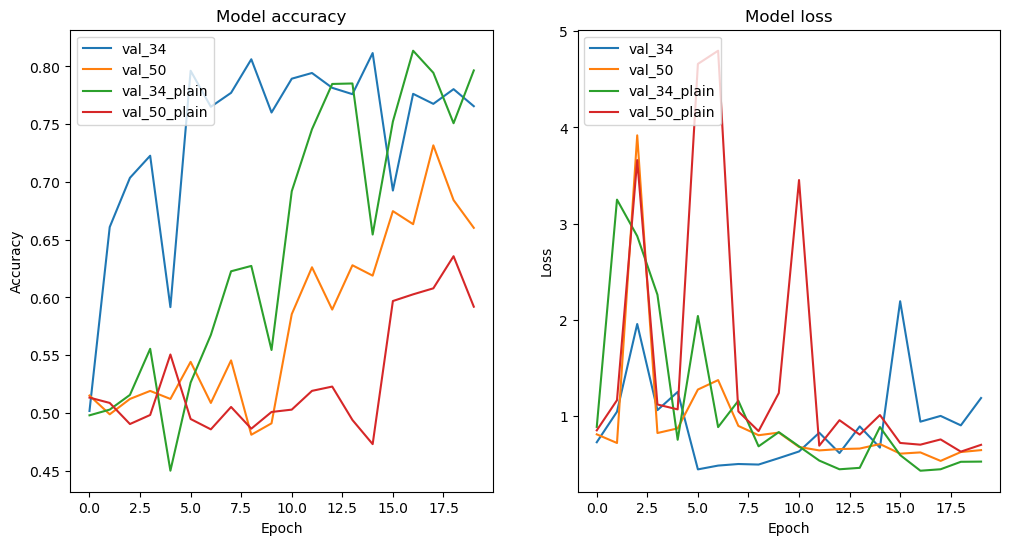

In [18]:
# 모델 학습 결과를 출력 (validation accuracy, validation loss)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_34.history['val_accuracy'])
plt.plot(history_50.history['val_accuracy'])
plt.plot(history_34_plain.history['val_accuracy'])
plt.plot(history_50_plain.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_34', 'val_50', 'val_34_plain', 'val_50_plain'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34.history['val_loss'])
plt.plot(history_50.history['val_loss'])
plt.plot(history_34_plain.history['val_loss'])
plt.plot(history_50_plain.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_34', 'val_50', 'val_34_plain', 'val_50_plain'], loc='upper left')

plt.show()